# Ciencia de Datos - TP6

## Integrantes

- Ambroa, Nicolás - 229/13 - ambroanicolas@hotmail.com
- Gaustein, Diego - 586/09 - diego@gaustein.com.ar

In [1]:
from collections import Counter
from functools import wraps
from itertools import chain
from string import punctuation, whitespace
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
import os
import pickle
import re
import pandas as pd
from pprint import pprint
from lxml import html
from nltk import sent_tokenize, word_tokenize, pos_tag, WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import sent_tokenize
from sklearn.metrics import mutual_info_score
from operator import itemgetter
import gensim
import spacy
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import random

random.seed(42)

lemmatizer = WordNetLemmatizer()
stopwords = frozenset(stopwords.words('english'))

%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 8)

def load_or_call(func):
    """ Decorador auxiliar para cachear resultados en un .pickle. """
    @wraps(func)
    def wrapper(*args, **kwargs):
        filename = '{}-{}-{}.pickle'.format(func.__name__, str(args), str(kwargs))
        if os.path.exists(filename):
            with open(filename, 'rb') as f:
                return pickle.load(f)
        else:
            res = func(*args, **kwargs)
            with open(filename, 'wb') as f:
                pickle.dump(res, f)
            return res

    return wrapper

## Asociación de palabras

### 1.1. Levantar el corpus AP, separando cada noticia como un elemento distinto en un diccionario `(<DOCNO>: <TEXT>)`.

In [2]:
parsed = html.parse('ap/ap.txt')
documents = {}
for document in parsed.iter('doc'):
    docno, article = document.getchildren()
    documents[docno.text.strip()] = article.text.strip()

print('Cargados', len(documents), 'articulos')


Cargados 2250 articulos


### 1.2. Calcular el tamaño del vocabulario.

In [3]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    elif treebank_tag.startswith('S'):
        return wordnet.ADJ_SAT
    else:
        return wordnet.NOUN  # El default es NOUN

def get_words_for_document(document):
    for sentence in sent_tokenize(document):
        tagged_sentence = pos_tag(sentence.split())
        for word, pos in tagged_sentence:
            # Lematizar
            word = lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos))
            # Strip punctuation
            word = word.strip(punctuation)
            # Lowercase
            word = word.lower()
            
            # Skip stopwords and punctuation
            if len(word) > 1 and word not in stopwords:
                yield word

@load_or_call
def get_word_count():
    c = Counter()
    for document in documents.values():
        c.update(get_words_for_document(document))
    return c
        
c = get_word_count()
cantidad_de_palabras = sum(c.values())
print(cantidad_de_palabras, 'palabras,', len(c), 'palabras distintas.')

548169 palabras, 41090 palabras distintas.


### 1.3. Para las 500 palabras con más apariciones, calcular el par más asociado según la medida presentada.

In [4]:
"""
Para cada palabra, aproximamos p(palabra) con su frecuencia relativa según el counter.
Tomamos las 500 con más apariciones y recorremos el texto. Cada vez que encontremos una de estas miramos en una
ventana (n=8) cuando aparece alguna de las otras, y le sumamos uno.
Esta es nuestra estimación de p(palabra1, palabra2). Finalmente calculamos la información mutua e imprimimos los
pares más asociados.
"""

def mirar_ventana_y_buscar(palabra_a_asociar, palabras, palabras_a_buscar, indice_inicial, longitud_de_ventana, asociaciones):
    # Arreglo los índices para no pasarme en caso de una ventana muy cercana a los extremos de la lista.
    if indice_inicial - longitud_de_ventana < 0:
        indice_inicial = 0
    else:
        indice_inicial -= longitud_de_ventana
    if indice_inicial + longitud_de_ventana > len(palabras):
        indice_final = len(palabras)
    else:
        indice_final = indice_inicial + longitud_de_ventana
       
    # Recorro los indices, buscando palabras a buscar que no sean la palabra a asociar.
    for indice in range(indice_inicial, indice_final):
        if palabras[indice] in palabras_a_buscar and palabras[indice] != palabra_a_asociar:
            subindice_dict = str(palabra_a_asociar) + " " +str(palabras[indice])
            # Si la encontre, aumento en uno la asociación entre ambas palabras.
            try:
                asociaciones[subindice_dict] += 1
            except IndexError:
                asociaciones[subindice_dict] = 1

@load_or_call
def contar_asociaciones_de_palabras():
    contador_asociaciones_de_palabras = Counter()
    # Recorremos el texto.
    for document in documents.values():
        palabras = document.split()
        for indice, palabra in enumerate(palabras):
            #Cada vez que encontremos una de ellas, miramos en una ventana de n=8.
            if palabra in palabras_con_mas_apariciones:
                mirar_ventana_y_buscar(palabra, palabras, palabras_con_mas_apariciones, indice, 8, contador_asociaciones_de_palabras)
    return contador_asociaciones_de_palabras

# Tomamos las 500 palabras con más apariciones.
palabras_y_apariciones = c.most_common(500)
palabras_con_mas_apariciones = [tupla[0] for tupla in palabras_y_apariciones]

asociaciones_de_palabras = contar_asociaciones_de_palabras()
suma_de_asociaciones_totales = sum(asociaciones_de_palabras.values())
informaciones_mutuas = Counter()
# Recorremos los pares y calculamos información mutua para cada uno.
for palabras, asociaciones in asociaciones_de_palabras.items():
    palabras_parseadas = palabras.split(" ")
    palabra_x = palabras_parseadas[0]
    palabra_y = palabras_parseadas[1]
    proba_x = c[palabra_x] / float(cantidad_de_palabras)
    proba_y = c[palabra_y] / float(cantidad_de_palabras)
    proba_conj_x_y  = asociaciones_de_palabras[palabras] / suma_de_asociaciones_totales
    inf_mutua_x_y = proba_conj_x_y / (proba_x*proba_y)
    informaciones_mutuas[palabras] = inf_mutua_x_y

# Finalmente imprimimos los 5 pares más asociados según la información mutua
print("Los 5 pares de palabras más asociadas según la medida de información mutua son: \n")
for palabra_y_info_mutua in informaciones_mutuas.most_common(5):
    print("* {0} con información mutua: {1}".format(palabra_y_info_mutua[0], palabra_y_info_mutua[1]))

Los 5 pares de palabras más asociadas según la medida de información mutua son: 

* index value con información mutua: 1838.0320849868358
* conference news con información mutua: 1421.3935232619224
* 30 average con información mutua: 1384.3817325708626
* executive chief con información mutua: 1228.8735910193982
* fell index con información mutua: 1106.339421879901


## Información Léxica

## Bajar de Project Gutenberg el libro de Darwin ON THE ORIGIN OF SPECIES.

### 2.1. Procesar el texto, tokenizando y eliminando signos de puntuación.

In [5]:
nlp = spacy.load('en_core_web_md', disable=['tagger', 'parser', 'ner'])
with open('on_the_origin_of_species.txt', 'r') as f:
    doc = nlp(f.read())

In [6]:
doc_without_punct = [token.text.lower() for token in doc if not (token.is_punct or token.is_space)]

### 2.2. Siguiendo el artículo de la sección, calcular la autocorrelación para estimar la distribución de la palabra a lo largo del texto.

In [7]:
# Por cada palabra, construimos un vector que tiene 1 en cada posición donde la palabra aparece

length = len(doc_without_punct)
important_words = ['plants', 'instinct', 'for']
dirac_vectors = {word: np.zeros(length) for word in important_words}

for index, word in enumerate(doc_without_punct):
    if word in important_words:
        dirac_vectors[word][index] = 1

In [8]:
# Por cada vector, creamos una serie de gaussianas de ancho 50 centradas en la posición de la palabra

gaussians = {word: list() for word in important_words}

for word, dirac_vector in dirac_vectors.items():
    for index in np.nonzero(dirac_vector)[0]:
        gaussian = norm(index, 50).pdf  # probability distribution function
        
        # Optimizacion: solo evaluamos la funcion en [-2000, +2000] alrededor del centro, pues fuera da 0
        bounds = max(index - 2000, 0), min((index + 2000), length)
        
        gaussians[word].append((bounds, gaussian))  

In [9]:
@load_or_call
def get_smoothed_vectors():
    smoothed_vectors = {word: np.zeros(length) for word in important_words}

    for word, vector in smoothed_vectors.items():
        for index, _ in tqdm(enumerate(vector)):
            functions = gaussians[word]
            sum_in_point = sum(function(index) for (lower, upper), function in functions if lower <= index <= upper)
            vector[index] = sum_in_point
    
    return smoothed_vectors

smoothed_vectors = get_smoothed_vectors()

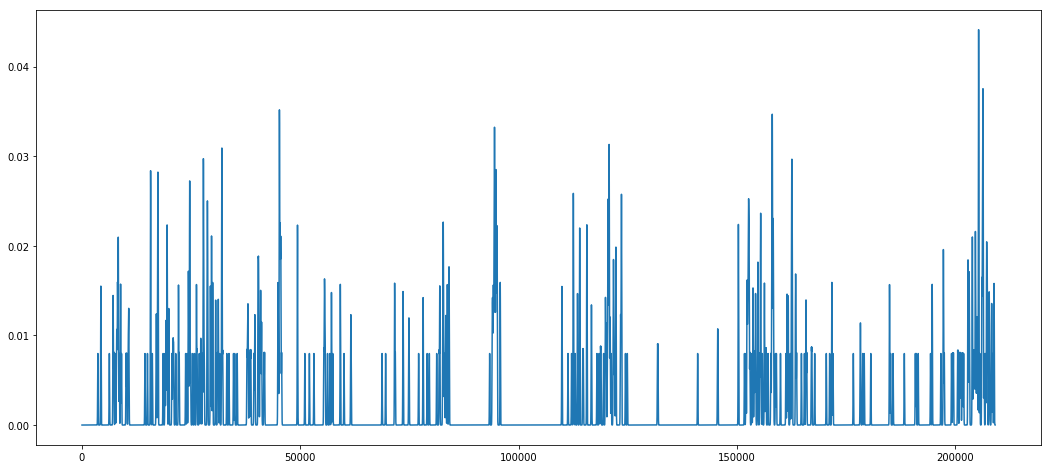

In [10]:
plt.plot(smoothed_vectors['plants'])

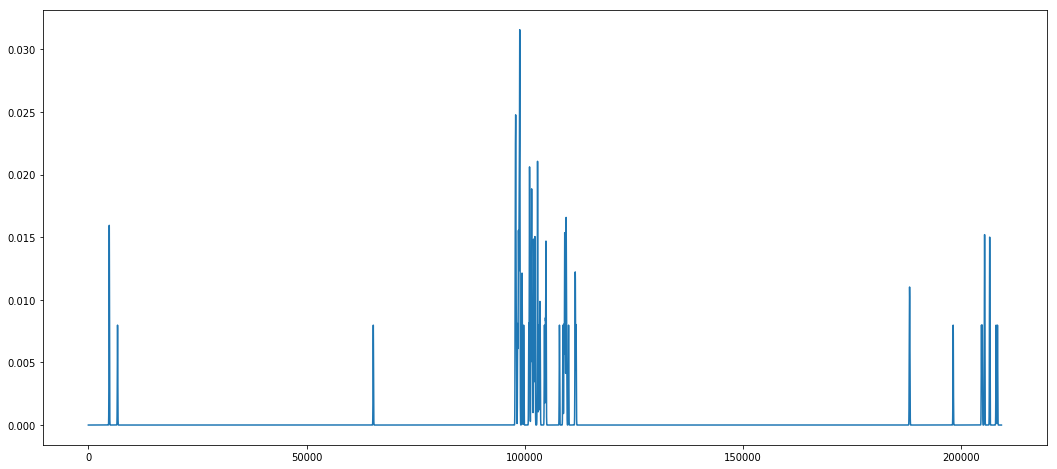

In [11]:
plt.plot(smoothed_vectors['instinct'])

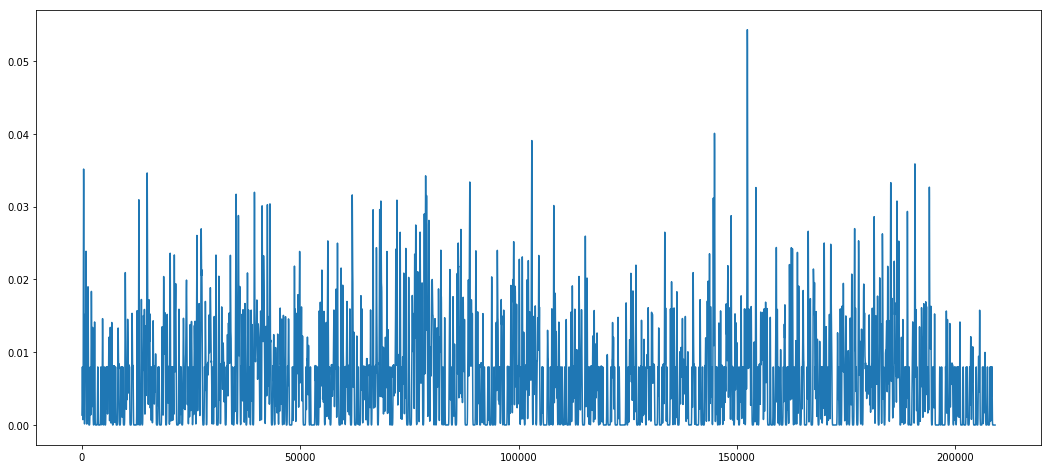

In [12]:
plt.plot(smoothed_vectors['for'])

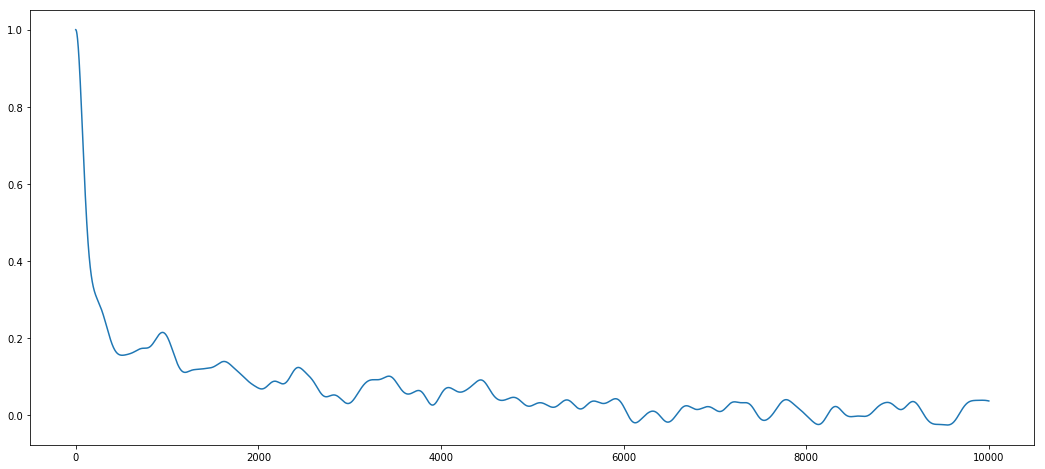

In [13]:
AUTOCORR_ITERATIONS = 10000

@load_or_call
def get_autocorr_data(vector):
    return [pd.Series(vector).autocorr(lag=lag) for lag in trange(AUTOCORR_ITERATIONS)]

plt.plot(get_autocorr_data(smoothed_vectors['plants']))

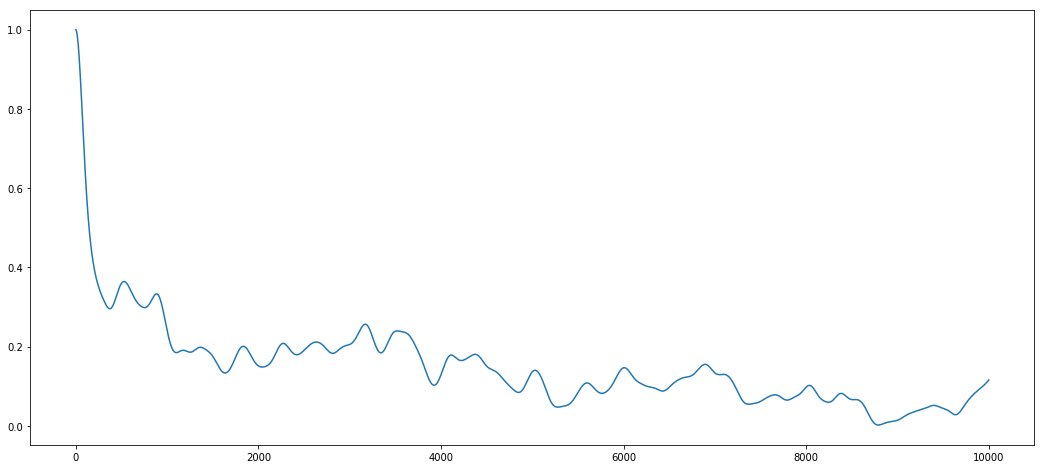

In [14]:
plt.plot(get_autocorr_data(smoothed_vectors['instinct']))

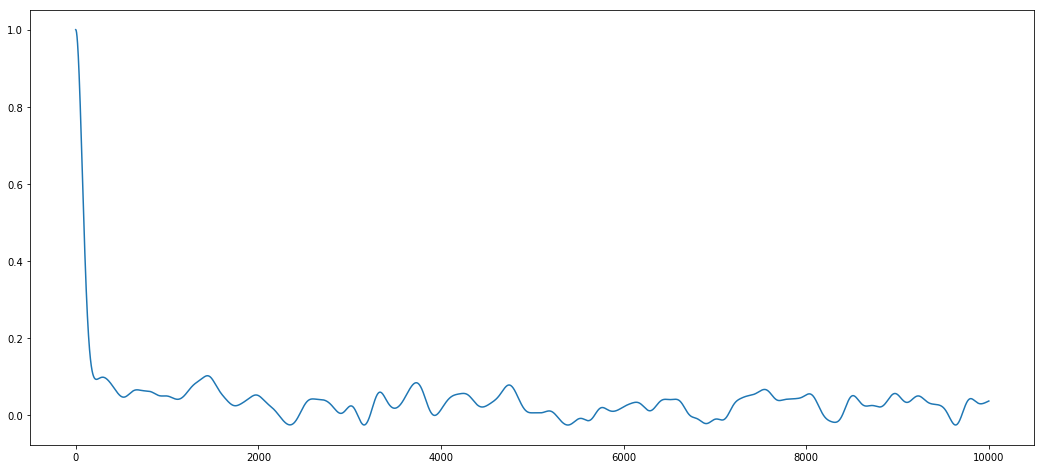

In [15]:
plt.plot(get_autocorr_data(smoothed_vectors['for']))

### 2.3 Calcular la entropía de una selección de 100 palabras que abarquen el rango de frecuencia de aparición en el libro, es decir elegir palabras que son muy frecuentes y otras de baja frecuencia

In [16]:
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))

def get_most_and_least_common(doc):
    random.seed(42)
    c = Counter(doc)
    
    most_common = dict([(word, occurences) for word, occurences in c.most_common()
                   if word not in stopwords and len(word) > 3][:50])
    least_common = dict(random.sample([(word, count) for word, count in c.items()
                                  if 4 < count < 10 and not hasNumbers(word) and len(word) > 3], 50))

    res = {word: count for word, count in chain(most_common.items(), least_common.items())}
    return res

most_and_least_common = get_most_and_least_common(doc_without_punct)

In [17]:
def get_entropies(doc, most_and_least_common):
    entropies = {word: 0 for word in most_and_least_common}
    for block in np.array_split(doc, 64):
        for word in most_and_least_common:
            occurrences_in_block = np.count_nonzero(block == word)
            if occurrences_in_block != 0:
                total_occurences = most_and_least_common[word]
                v = occurrences_in_block / total_occurences
                entropies[word] -= v * np.log2(v)
    return entropies

entropies = get_entropies(doc_without_punct, most_and_least_common)
for word, entropy in entropies.items():
    print(word, '- entropy:', entropy, '- total occurences:', most_and_least_common[word])

species - entropy: 5.71672085387 - total occurences: 1921
would - entropy: 5.65612174458 - total occurences: 703
many - entropy: 5.80973058245 - total occurences: 614
forms - entropy: 5.28896579573 - total occurences: 564
selection - entropy: 5.39542646629 - total occurences: 555
natural - entropy: 5.48095033376 - total occurences: 530
varieties - entropy: 5.00542956807 - total occurences: 484
plants - entropy: 5.25524580165 - total occurences: 465
animals - entropy: 5.60974177022 - total occurences: 436
thus - entropy: 5.74057427753 - total occurences: 390
several - entropy: 5.63219495818 - total occurences: 367
different - entropy: 5.75431338588 - total occurences: 365
great - entropy: 5.77824296638 - total occurences: 362
distinct - entropy: 5.51058279516 - total occurences: 359
life - entropy: 5.47303668865 - total occurences: 349
case - entropy: 5.7068629152 - total occurences: 343
nature - entropy: 5.64716725256 - total occurences: 328
much - entropy: 5.77156985824 - total occure

### 2.4 Calcular la entropía de las palabras seleccionadas anteriormente, randomizando su posición en el texto. Comparar con los resultados del punto anterior.

In [18]:
shuffled_text = random.sample(doc_without_punct, k=len(doc_without_punct))
shuffled_entropies = get_entropies(shuffled_text, most_and_least_common)
for word, entropy in shuffled_entropies.items():
    print(word, '- entropy:', entropy, '- total occurences:', most_and_least_common[word])

species - entropy: 5.97487836582 - total occurences: 1921
would - entropy: 5.93381665063 - total occurences: 703
many - entropy: 5.90338967455 - total occurences: 614
forms - entropy: 5.89693337799 - total occurences: 564
selection - entropy: 5.94506134233 - total occurences: 555
natural - entropy: 5.92770670778 - total occurences: 530
varieties - entropy: 5.93006146829 - total occurences: 484
plants - entropy: 5.91057271556 - total occurences: 465
animals - entropy: 5.85692405112 - total occurences: 436
thus - entropy: 5.88662047178 - total occurences: 390
several - entropy: 5.85411000737 - total occurences: 367
different - entropy: 5.85976192223 - total occurences: 365
great - entropy: 5.89814290292 - total occurences: 362
distinct - entropy: 5.85560166722 - total occurences: 359
life - entropy: 5.88601673171 - total occurences: 349
case - entropy: 5.87959024884 - total occurences: 343
nature - entropy: 5.83754655976 - total occurences: 328
much - entropy: 5.85389761449 - total occur

Text(0,0.5,'Entropía')

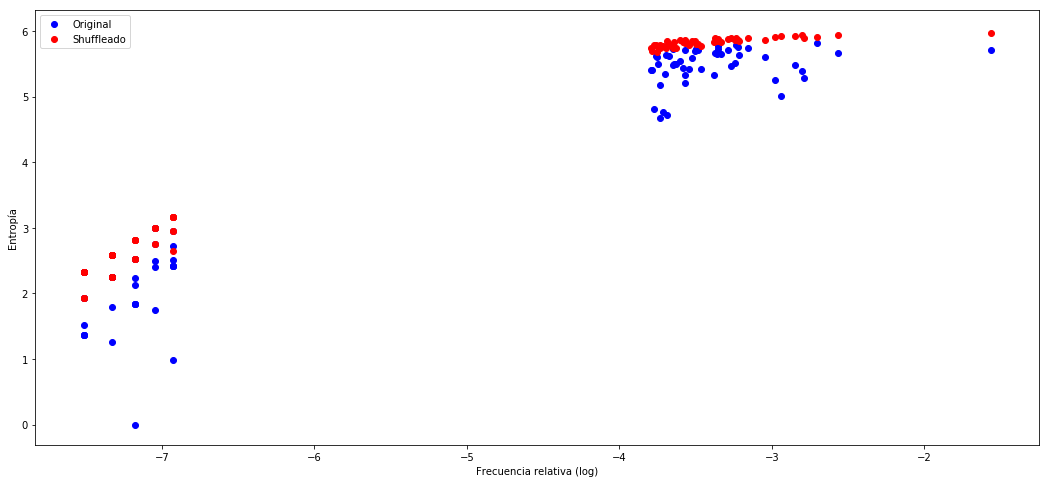

In [19]:
total_words = len(Counter(doc_without_punct))
x, y, y2 = [], [], []
for word, entropy in entropies.items():
    freq = np.log(most_and_least_common[word] / total_words)
    x.append(freq)
    y.append(entropy)
    y2.append(shuffled_entropies[word])

fig, ax = plt.subplots()
plt.scatter(x, y, c='b', label='Original')
plt.scatter(x, y2, c='r', label='Shuffleado')
ax.legend()
plt.xlabel('Frecuencia relativa (log)')
plt.ylabel('Entropía')

Vemos que, consistentemente con el trabajo de Zanette et al, la entropía de las palabras en el texto shuffleado es mayor que en el texto original. Además, las palabras con muchas apariciones tienen en promedio una entropía mucho mayor a las palabras poco frecuentes

## Word embeddings, distancia semántica y Word-Net

### 3.1. Utilizando el test WordSim353 , comparar el rendimiento entre LSA y Word2Vec.

In [20]:
# Voy a ejecutar éste código solamente si no lo ejecute antes.
if not os.path.exists('obtener_metrica_de_similitud_por_modelo-()-{}.pickle'):
    
    # Primero el modelo Word2Vec.
    # Para utilizar éste modelo, se debe descargar el link puesto debajo y ubicarlo en la carpeta source del proyecto.
    # Para el model de Google: http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/
    word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
    
    # Luego, el modelo LSA.
    # Primero, tenemos que armar el corpus para LSA adaptándonos al formato TF-IDF.
    oraciones = []
    # Pasamos todos los documentos del corpus a la lista oraciones, limpiando en el proceso.
    directorio = os.fsencode('brown/')
    for archivo in os.listdir(directorio):
        filename = os.fsdecode(archivo)
        nombre_completo = 'brown/' + filename
        with open(nombre_completo) as f:
            lineas = f.read().splitlines()
            lineas_limpias = [" ".join(word.split("/")[0] for word in s.split()) for s in lineas]
            oraciones += lineas_limpias

    # Sacamos palabras que queremos ignorar, espacios vacíos, etc. 
    ignorables = list('for a of the and to in if from by'.split()) + list(punctuation) + list(whitespace) + [[]]

    # Armamos una gran lista de palabras por documento
    palabras = [[word for word in document.lower().split() if word not in ignorables]
                 for document in oraciones if document]

    lsa_dicionario = gensim.corpora.Dictionary(palabras)
    # doc2bow() cuenta la cantidad de apariciones de c/palabra, transforma la palabra a su entero_id y devuelve
    # el resultado como un vector esparso.
    lsa_corpus = [lsa_dicionario.doc2bow(palabra) for palabra in palabras]

    # Inicializamos modelo TF-IDF.
    modelo_tfidf = gensim.models.TfidfModel(lsa_corpus)
    corpus_tfidf = modelo_tfidf[lsa_corpus]
    if not os.path.exists('lsi_model'):
        # Finalmente, tenemos el modelo LSI (LSA).
        modelo_lsi = gensim.models.LsiModel(corpus_tfidf, id2word=lsa_dicionario, num_topics=300)
        modelo_lsi.save('lsi_model')
    else:
        modelo_lsi = gensim.models.LsiModel.load('lsi_model')

#### Testeamos similitud con la medida conocida como Cosine Similarity.

In [21]:
def obtener_similitud_lsa(palabra_1, palabra_2):
    doc = palabra_1 + " " + palabra_2
    similitud_query = lsa_dicionario.doc2bow(doc.lower().split())
    similitud_lsi = modelo_lsi[similitud_query]
    maximo = 0
    for tupla in similitud_lsi:
        if tupla[1] > maximo:
            maximo = tupla[1]
    return maximo

@load_or_call
def obtener_metrica_de_similitud_por_modelo():
    similitudes_por_modelo = {'WordSim353': {}, 'Word2Vec': {}, 'LSA': {}}
    similitud_test_filename = 'wordsimtest/wordsim_similarity_goldstandard.txt'
    with open(similitud_test_filename, 'rb') as similitud_test_file:
        for line in similitud_test_file.readlines():
            # Parseo línea de palabras similares.
            linea = line.decode('UTF-8').split()
            primera_palabra = linea[0]
            segunda_palabra = linea[1]
            subindice = primera_palabra + " " + segunda_palabra
            # Veo similaridad en WordSim353.
            similitudes_por_modelo['WordSim353'][subindice] = linea[2]
            # Veo similarity en Word2Vec.
            similitudes_por_modelo['Word2Vec'][subindice] = word2vec_model.wv.similarity(primera_palabra, segunda_palabra)
            similitudes_por_modelo['LSA'][subindice] = obtener_similitud_lsa(primera_palabra, segunda_palabra)
    return similitudes_por_modelo

In [22]:
similitudes_por_modelo = obtener_metrica_de_similitud_por_modelo()

In [23]:
print("La similitud para Word2Vec en el caso de tiger cat es: {0}".format(similitudes_por_modelo['Word2Vec']['tiger cat']))

La similitud para Word2Vec en el caso de tiger cat es: 0.5172961902020222


In [24]:
print("La similitud para LSA en el caso de tiger cat es: {0}".format(similitudes_por_modelo['LSA']['tiger cat']))

La similitud para LSA en el caso de tiger cat es: 0.004632709012058887


Recortamos el input de similitudes para que no ensucie el documento. En general, y como se aprecia en el ejemplo, el modelo Word2Vec presenta resultados con similitudes más altas en sus conjuntos de palabras comparado con el modelo LSA. Creemos que ésto se debe a que el set de entrenamiento del modelo Word2Vec provisto por Google es mucho más robusto y amplio que el brown corpus de LSA (que data de 1961).

### 3.2 Comparar los distintos word embeddings con las medidas definidas en WordNet.

In [25]:
# Obtenemos todas las palabras y comparamos la similitud provista por WordNet contra los modelos ya estudiados
palabras = list(similitudes_por_modelo['LSA'].keys())
for palabra in palabras:
    palabra_uno = palabra.split()[0]
    palabra_dos = palabra.split()[1]
    synset_uno = wordnet.synsets(palabra_uno)[0]
    synset_dos = wordnet.synsets(palabra_dos)[0]
    similarity = synset_uno.wup_similarity(synset_dos)
    similitudes_por_modelo['WordNet'][palabra] = similarity
    
print("Veamos como se compara la similitud entre palabras entre WordNet y los distintos embeddings:\n")
for i in range(0, 10):
    palabra = palabras[i]
    similarity_word2vec = similitudes_por_modelo['Word2Vec'][palabra]
    similarity_lsa = similitudes_por_modelo['LSA'][palabra]
    similarity_wordnet = similitudes_por_modelo['WordNet'][palabra]
    print("Para las palabras {0} el ranking de similitudes es:\n Word2Vec = {1}, LSA = {2}, WordNet = {3}".format(palabra, similarity_word2vec, similarity_lsa, similarity_wordnet))


Veamos como se compara la similitud entre palabras entre WordNet y los distintos embeddings:

Para las palabras tiger cat el ranking de similitudes es:
 Word2Vec = 0.5172961902020222, LSA = 0.004632709012058887, WordNet = 0.5454545454545454
Para las palabras tiger tiger el ranking de similitudes es:
 Word2Vec = 1.0, LSA = 0.0031352919205985554, WordNet = 0.75
Para las palabras plane car el ranking de similitudes es:
 Word2Vec = 0.37796983289317077, LSA = 0.1470405288235886, WordNet = 0.6666666666666666
Para las palabras train car el ranking de similitudes es:
 Word2Vec = 0.3402561051227599, LSA = 0.1531544183019575, WordNet = 0.6666666666666666
Para las palabras television radio el ranking de similitudes es:
 Word2Vec = 0.6114970653740064, LSA = 0.028844617336219125, WordNet = 0.9
Para las palabras media radio el ranking de similitudes es:
 Word2Vec = 0.3899160770063179, LSA = 0.027413281450257825, WordNet = 0.8235294117647058
Para las palabras bread butter el ranking de similitudes es